In [1]:
import numpy as np 
from pandas import Series, DataFrame
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import catboost
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [3]:
#original catalog
path = r'C:\Users\pedro\OneDrive - Universidade do Porto\Imagens\OneDrive - Universidade do Porto\Ambiente de Trabalho\UNI\Mestrado\1º semestre\Machine Learning\Projeto\dados\catalog.parquet'
catalog = pd.read_parquet(path)

In [4]:
catalog

,ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,1,150.477592,2.328928,14051.033584,24912.034028,0.019432,1.154464e-02,150.477638,2.328963,b'181_32',...,-9.140639,-9.116661,-9.089199,-9.063887,-9.050062,0.038461,0.038461,0.038461,0.038461,0.038461
1,2,150.477978,2.329170,14041.782916,24917.839703,0.102373,1.305541e-01,150.477974,2.329169,b'181_33',...,-8.737532,-8.618159,-8.478306,-8.337237,-8.213281,0.018737,0.018737,0.018737,0.018737,0.018737
2,3,150.477024,2.329483,NaN,NaN,NaN,NaN,150.477111,2.329667,b'181_34',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,150.477312,2.330573,14057.758498,24951.520772,0.098902,9.468231e-02,150.477316,2.330574,b'181_38',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,150.474793,2.332136,14118.162336,24989.006449,0.017773,3.539389e-02,150.474843,2.332179,b'181_39',...,-7.940726,-7.940726,-7.940726,-7.940726,-7.940726,0.042471,0.042471,0.042471,0.042471,0.042471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964501,964502,150.068793,2.870516,23853.815263,37909.784856,0.000065,8.288924e-05,150.068801,2.870500,b'283_5270',...,-9.524284,-9.095250,-8.751433,-8.005345,-8.005345,1.873661,1.873661,1.873661,1.873661,1.873661
964502,964503,150.072295,2.871735,23769.881726,37939.037182,0.000001,4.420735e-06,150.072305,2.871736,b'283_5271',...,-7.940726,-7.940726,-7.940726,-7.940726,-7.940726,1.129562,1.232992,1.334211,1.445236,1.543489
964503,964504,150.071539,2.874151,23787.988894,37997.043844,0.000004,6.963900e-07,150.071549,2.874164,b'283_5272',...,-10.023261,-9.878627,-9.719501,-9.560150,-9.434907,0.769145,0.817205,0.953520,1.319708,1.572936
964504,964505,150.088646,2.876782,23377.925486,38060.183349,0.098302,2.854818e-02,150.088643,2.876837,b'283_5273',...,-9.503490,-9.411257,-9.333571,-9.192708,-9.077335,0.042147,0.042147,0.042147,0.042147,0.042147


In [5]:
# new catalog
# filter out unreliable observations
cata = catalog[catalog.filter(like='FLAG').eq(0).all(axis=1)] 

In [6]:
features = ['lp_zBEST']
for col_name in list(cata.columns.values):
        if 'MAG' in col_name: 
            features.append(col_name)

# List of labels
labels =['lp_mass_best','lp_SFR_best']

#choose only data from galaxies
cata = cata[cata['lp_type'] == 0] 

# labels range 
cata = cata.loc[(cata['lp_zBEST'] > 0.2) & (cata['lp_zBEST'] < 5.5)]  
cata = cata.loc[(cata['lp_SFR_best'] > -4) & (cata['lp_SFR_best'] < 3)]  

# new catalog
columns = features + labels
cat = cata[columns]

In [7]:
cat = cat.dropna(subset=labels)  # Drop NaN in targets' columns

#final table
cat = cat.loc[cat.index] 

In [8]:
cat

,lp_zBEST,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,HSC_g_MAG,HSC_g_MAGERR,HSC_r_MAG,HSC_r_MAGERR,HSC_i_MAG,...,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ACS_F814W_MAG,ACS_F814W_MAGERR,lp_mass_best,lp_SFR_best
0,1.5930,26.089124,0.034136,26.013149,0.027118,26.002327,0.026108,25.887478,0.032539,25.977980,...,25.135260,0.105391,NaN,NaN,NaN,NaN,25.791597,0.159766,8.52185,0.2347
4,2.8698,26.614236,0.054797,26.686707,0.050745,25.923896,0.023349,25.797231,0.030013,25.991617,...,25.417095,0.206961,NaN,NaN,NaN,NaN,26.037453,0.105512,8.05107,0.4251
5,1.5139,27.835780,0.169823,28.148341,0.193865,28.088120,0.171603,27.633024,0.160903,27.650674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.06661,-1.1460
11,0.7070,24.957998,0.017385,25.043569,0.015100,24.967641,0.013929,24.509829,0.012705,23.990104,...,24.229948,0.175698,NaN,NaN,NaN,NaN,24.015520,0.074395,8.64422,-0.1711
16,0.5725,26.670439,0.057265,26.522136,0.042355,26.656828,0.045123,26.665598,0.065118,26.635781,...,NaN,NaN,NaN,NaN,NaN,NaN,27.016584,0.254684,6.69292,-0.6479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964428,0.5593,23.623760,0.004034,NaN,NaN,23.604851,0.002866,23.406177,0.003119,23.248782,...,22.292629,0.025234,23.056145,1.297706,NaN,NaN,23.032091,0.015964,7.93811,0.1261
964436,1.7660,26.549842,0.067882,NaN,NaN,NaN,NaN,NaN,NaN,24.378633,...,20.503550,0.011555,21.200373,0.252214,21.45981,0.457638,23.381042,0.030234,11.23245,-0.3316
964438,0.3207,26.158828,0.044645,NaN,NaN,25.315184,0.022614,24.806737,0.010618,24.591523,...,24.152298,0.059791,NaN,NaN,NaN,NaN,24.089319,0.038112,7.47894,-1.7330
964440,0.8165,26.879697,0.050111,NaN,NaN,26.704352,0.045443,NaN,NaN,25.143741,...,24.134888,0.067892,NaN,NaN,NaN,NaN,24.736200,0.052431,7.63867,-0.7851


In [9]:
X = cat[features] #features matrix
y = cat[labels]  #labels matrix

In [10]:
import time
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import pandas as pd

# Define the output labels and column names for the predictions
labels = ['lp_mass_best', 'lp_SFR_best']
columns_df = ['lightgbm', 'catboost']

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the regression models with their respective hyperparameters
models = [
    LGBMRegressor(
        objective='regression', 
        n_jobs=-1,
        n_estimators=1000,
        max_depth=8,
        subsample=0.8,
        reg_alpha=0.1,
        verbosity=-1
    ),
    CatBoostRegressor(
        loss_function='RMSE',   
        logging_level='Silent',
        n_estimators=1000,
        l2_leaf_reg=0.1,
        max_depth=8
    )
]

# Dictionary to store predictions
pred_dict = {}

# Iterate through the models
for i, method in enumerate(models):
    model_name = columns_df[i]
    print(f"\nTraining {model_name}...")

    # Measure the execution time of training
    start_time = time.time()

    # Use MultiOutputRegressor to handle multiple output variables
    regressor = MultiOutputRegressor(method)
    regressor.fit(X_train, y_train)
    
    # Make predictions on the validation set
    pred = regressor.predict(X_val)

    # Calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time

    # Print the execution time
    print(f"Execution time for {model_name}: {execution_time:.2f} seconds")

    # Store the predictions in the dictionary
    for j, label in enumerate(labels):
        col_name = model_name + '_' + label
        pred_dict[col_name] = pred[:, j]

# Create a DataFrame to store the predictions
pred_df = pd.DataFrame(pred_dict, index=y_val.index)



Training lightgbm...
Execution time for lightgbm: 40.56 seconds

Training catboost...
Execution time for catboost: 140.44 seconds


In [11]:
pred_df

,lightgbm_lp_mass_best,lightgbm_lp_SFR_best,catboost_lp_mass_best,catboost_lp_SFR_best
656880,8.084722,0.616244,8.081604,0.577146
335181,8.461600,0.147200,8.444927,0.166390
592173,8.565468,0.293939,8.583333,0.364888
299809,6.832933,-0.393365,7.149382,-0.397151
742872,6.791548,-2.958552,6.665413,-2.534916
...,...,...,...,...
558720,7.230936,-0.331599,7.207065,-0.235985
137258,9.985752,1.256645,9.919508,1.394127
742768,8.871662,0.582578,9.005835,0.506803
460791,6.410068,-1.286639,6.454807,-1.382294


Keys of evals_result: dict_keys(['learn'])


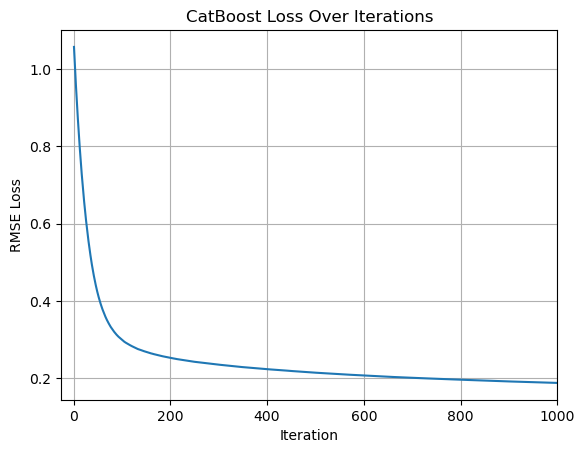

In [12]:
# Extract the loss values from the CatBoostRegressor
if isinstance(regressor.estimators_[0], CatBoostRegressor):
    evals_result = regressor.estimators_[0].evals_result_
    
    # Print the keys of evals_result to inspect its structure
    print("Keys of evals_result:", evals_result.keys())

    # Assuming the structure is evals_result_['learn'] or evals_result_['validation']
    if 'validation' in evals_result:
        loss_values = evals_result['validation']['RMSE']
    elif 'learn' in evals_result:
        loss_values = evals_result['learn']['RMSE']
    else:
        raise KeyError("Could not find 'validation' or 'learn' in evals_result")

    # Plot CatBoost loss values
    plt.plot(np.arange(1, len(loss_values) + 1), loss_values)
    plt.xlabel('Iteration')
    plt.ylabel('RMSE Loss')
    plt.title('CatBoost Loss Over Iterations')
    plt.grid()
    plt.xlim(-25, 1000)
    plt.show()

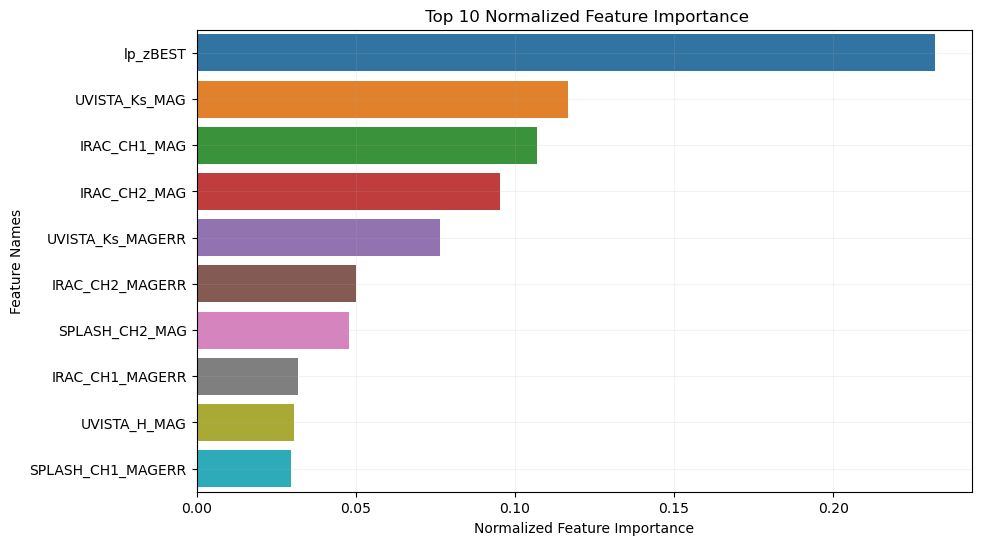

In [13]:
#features importances

def plot_feature_importance(importance, names):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Normalize feature importance values
    normalized_importance = feature_importance / feature_importance.sum()

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': normalized_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Select only the top 10 features
    top_10_features = fi_df.head(10)

    # Define size of bar plot
    plt.figure(figsize=(10, 6))
    # Plot Seaborn bar chart
    sns.barplot(x=top_10_features['feature_importance'], y=top_10_features['feature_names'])
    # Add chart labels
    plt.title(' Top 10 Normalized Feature Importance')
    plt.xlabel('Normalized Feature Importance')
    plt.ylabel('Feature Names')

features_importances = regressor.estimators_[0].feature_importances_
names = X_train.columns

plot_feature_importance(features_importances, names)
plt.grid(True,alpha=0.15)

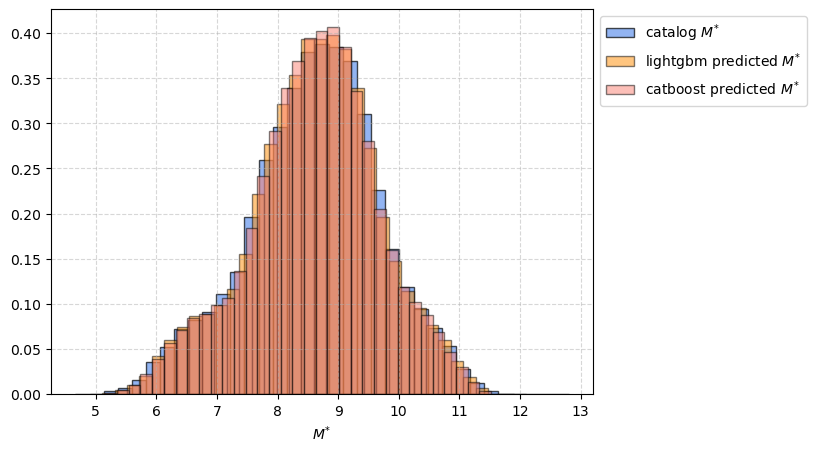

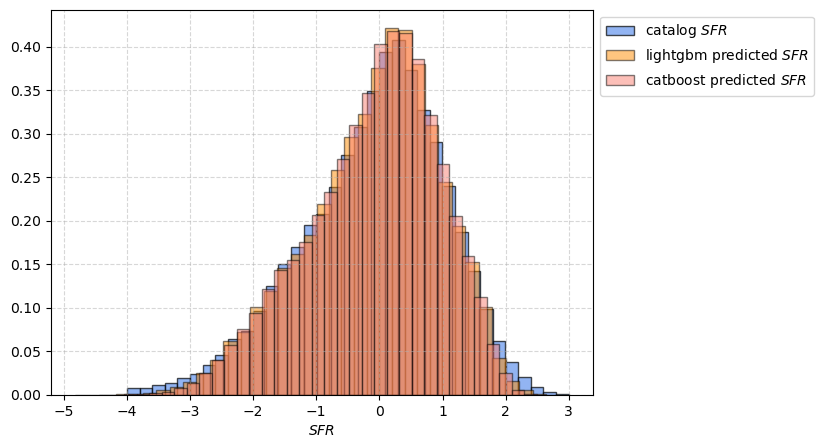

In [14]:
label = 'lp_mass_best'
colors = ['cornflowerblue', 'darkorange', 'salmon']

fig_hist, ax = plt.subplots(figsize=(7, 5))
ax.hist(y_val[label], 35, facecolor=colors[0], edgecolor='black', alpha=0.7, label='catalog {}'.format(r'$M^{*}$'), density=True)
ax.hist(pred_df['lightgbm_{}'.format(label)], 35, facecolor=colors[1], edgecolor='black', alpha=0.5, label='lightgbm predicted {}'.format(r'$M^{*}$'), density=True)
ax.hist(pred_df['catboost_{}'.format(label)], 35, facecolor=colors[2], edgecolor='black', alpha=0.5, label='catboost predicted {}'.format(r'$M^{*}$'), density=True)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel(r'$M^{*}$')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
plt.show()


label = 'lp_SFR_best'

fig_hist, ax = plt.subplots(figsize=(7, 5))
ax.hist(y_val[label], 35, facecolor=colors[0], edgecolor='black', alpha=0.7, label='catalog {}'.format(r'$SFR$'), density=True)
ax.hist(pred_df['lightgbm_{}'.format(label)], 35, facecolor=colors[1], edgecolor='black', alpha=0.5, label='lightgbm predicted {}'.format(r'$SFR$'), density=True)
ax.hist(pred_df['catboost_{}'.format(label)], 35, facecolor=colors[2], edgecolor='black', alpha=0.5, label='catboost predicted {}'.format(r'$SFR$'), density=True)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel(r'$SFR$')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
plt.show()


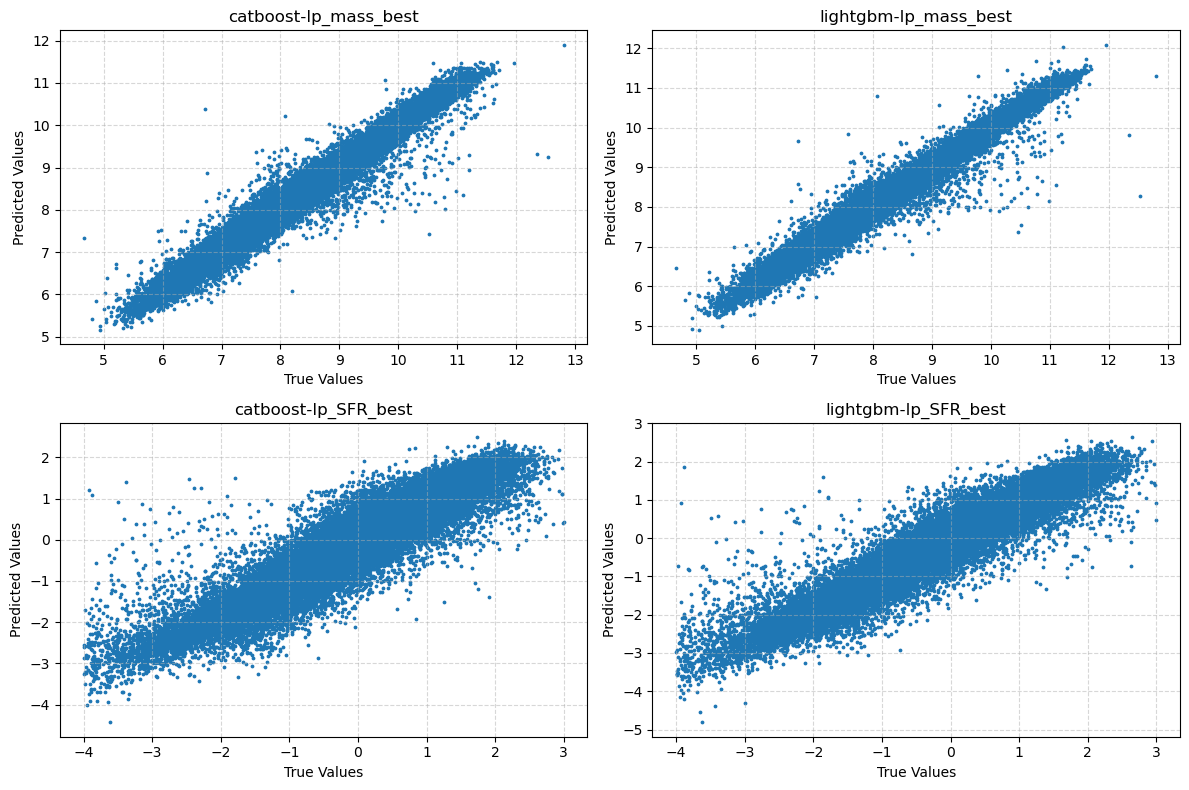

In [15]:
#true vs predicted values

models = ['catboost', 'lightgbm']

fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3
        axes[i, j].scatter(y_val[label], pred_df['{}_{}'.format(model, label)], s=marker_size)
        
        axes[i, j].grid(True, linestyle='--', alpha=0.5)

        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

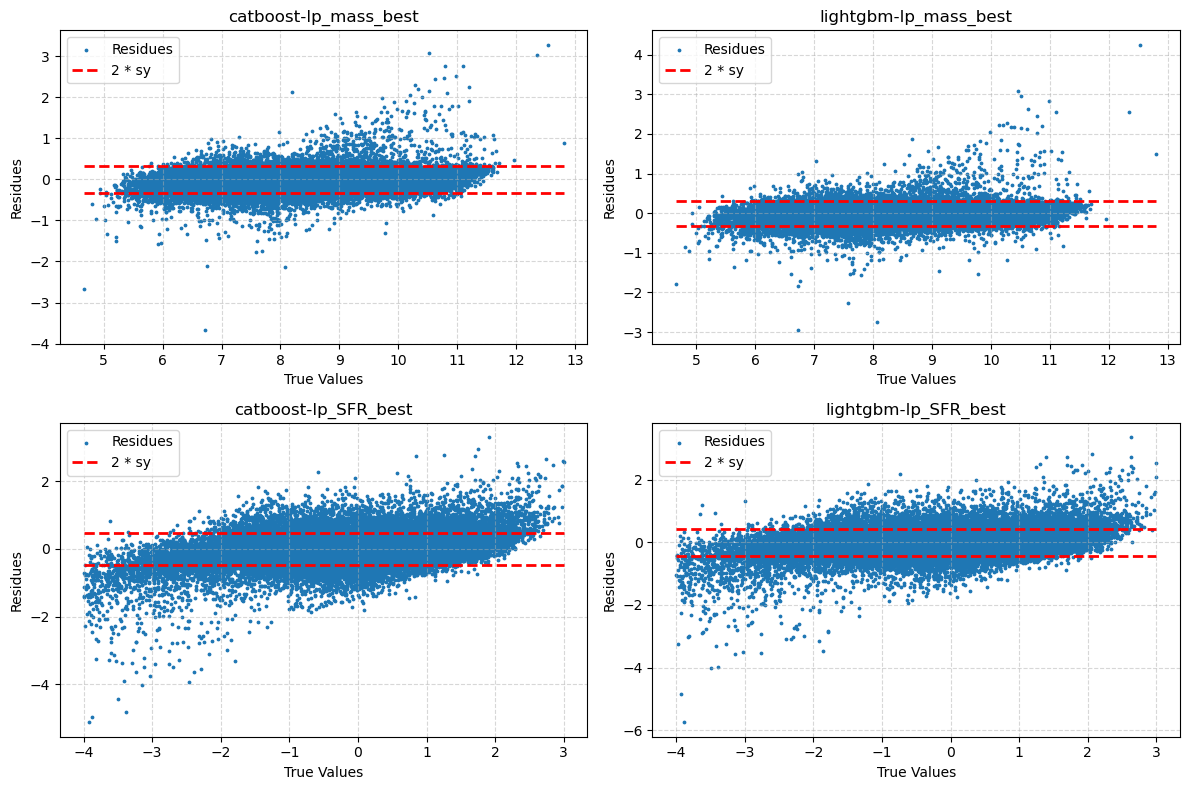

In [16]:
# residues graph

fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3
        
        diff = y_val[label] - pred_df['{}_{}'.format(model, label)]
        
        axes[i, j].scatter(y_val[label], diff, s=marker_size, label='Residues')
        
        # 2*sy
        sy = np.std(np.sqrt(np.abs(y_val[label] - pred_df['{}_{}'.format(model, label)])))
        axes[i, j].hlines(2 * sy, min(y_val[label]), max(y_val[label]), color='red', linestyle='dashed', linewidth=2, label='2 * sy')
        axes[i, j].hlines(-2 * sy, min(y_val[label]), max(y_val[label]), color='red', linestyle='dashed', linewidth=2)
        
        axes[i, j].grid(True, linestyle='--', alpha=0.5)

        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Residues')

        axes[i, j].legend()

plt.tight_layout()
plt.show()

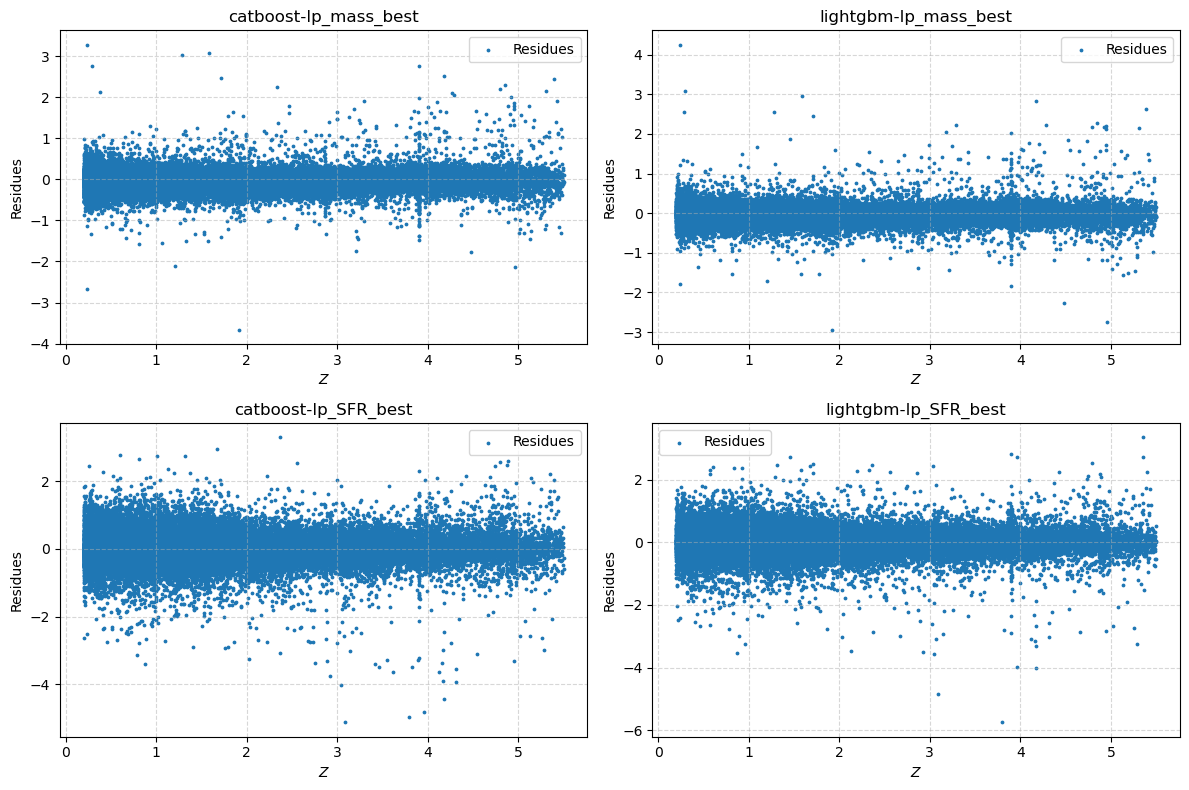

In [17]:
#residues vs redshift

models = ['catboost', 'lightgbm']

fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        marker_size = 3

        diff = y_val[label] - pred_df['{}_{}'.format(model, label)]

        axes[i, j].scatter(X_val['lp_zBEST'], diff, s=marker_size, label='Residues')

        axes[i, j].grid(True, linestyle='--', alpha=0.5)

        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel(r'$Z$')
        axes[i, j].set_ylabel('Residues')

        axes[i, j].legend()

plt.tight_layout()
plt.show()

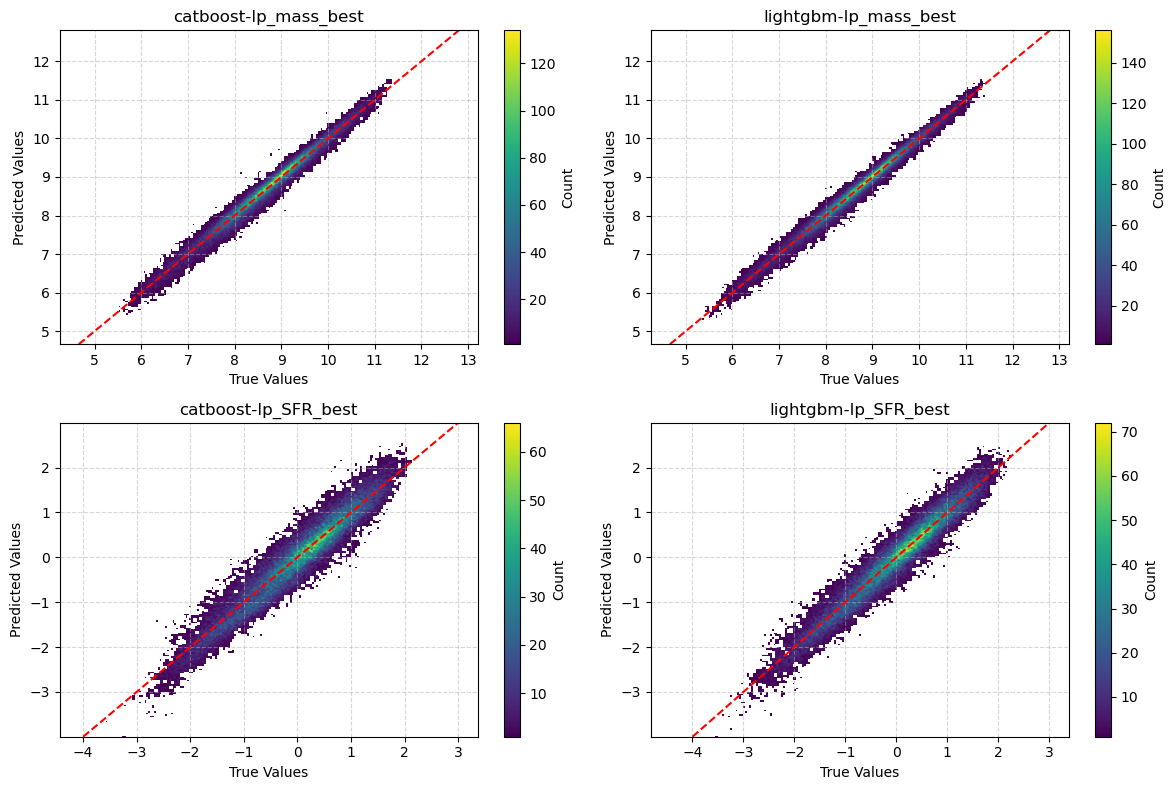

In [18]:
models = ['catboost', 'lightgbm']

# Set up the figure and axes
fig, axes = plt.subplots(nrows=len(labels), ncols=len(models), figsize=(12, 4 * len(labels)))

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        # Create a 2D histogram with higher resolution (more bins)
        counts, x_edges, y_edges = np.histogram2d(y_val[label], pred_df['{}_{}'.format(model, label)], bins=200)
        
        # Mask areas with zero counts
        counts_masked = np.ma.masked_where(counts == 0, counts)
        
        # Plot the 2D histogram using a color map
        im = axes[i, j].imshow(counts_masked, extent=[y_edges[0], y_edges[-1], x_edges[0], x_edges[-1]], cmap="viridis", aspect="auto", origin="lower")

        
        # Add color bar
        cbar = fig.colorbar(im, ax=axes[i, j], label='Count')

        # Add a red dashed line for y=x
        axes[i, j].plot([min(y_val[label]), max(y_val[label])], [min(y_val[label]), max(y_val[label])], linestyle='--', color='red')

        axes[i, j].grid(True, linestyle='--', alpha=0.5)
        axes[i, j].set_title(f'{model}-{label}')
        axes[i, j].set_xlabel('True Values')
        axes[i, j].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()


- Ploting each graph individually for improved details

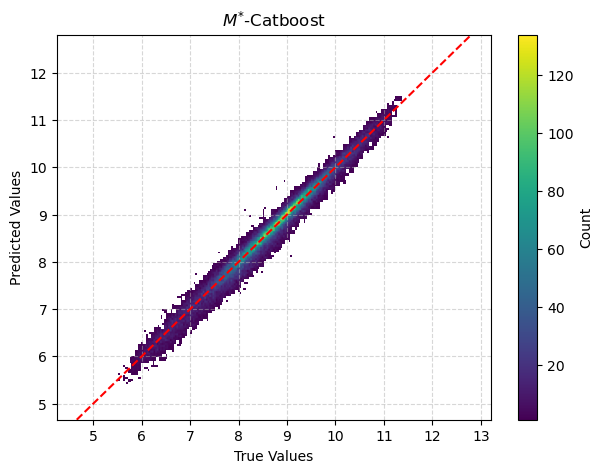

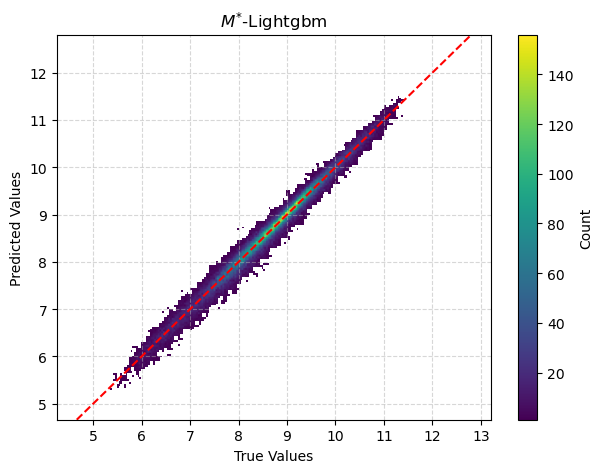

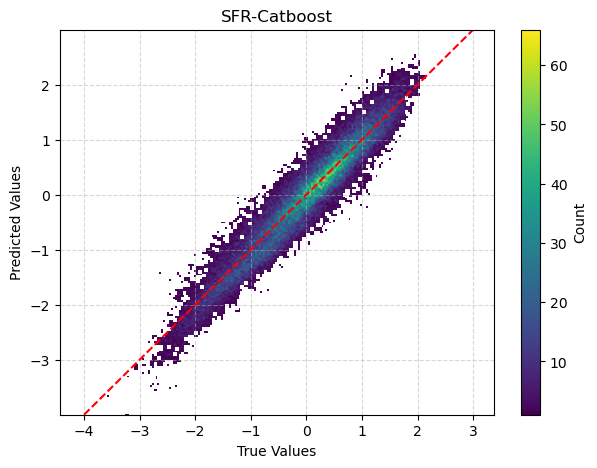

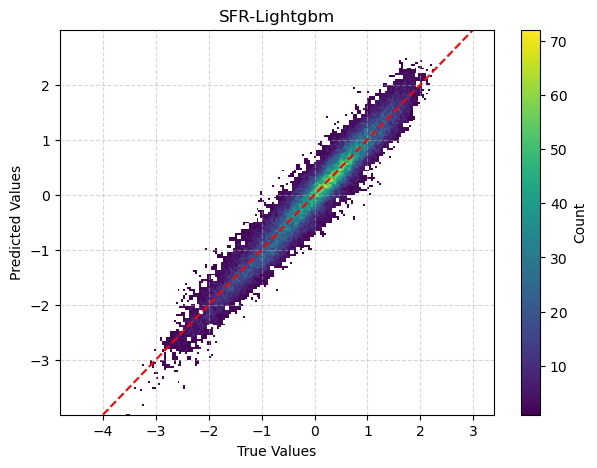

In [19]:
models = ['catboost', 'lightgbm']

# Dictionary to map abbreviated labels to full names
label_mapping = {
    'lp_SFR_best': r'SFR',
    'lp_mass_best':r'$M^{*}$'
    # Add more mappings as needed
}

for i, label in enumerate(labels):
    for j, model in enumerate(models):
        fig, ax = plt.subplots(figsize=(7, 5))
        
        # Create a 2D histogram with higher resolution (more bins)
        counts, x_edges, y_edges = np.histogram2d(y_val[label], pred_df['{}_{}'.format(model, label)], bins=200)
        
        # Mask areas with zero counts
        counts_masked = np.ma.masked_where(counts == 0, counts)
        
        # Plot the 2D histogram using a color map
        im = ax.imshow(counts_masked, extent=[y_edges[0], y_edges[-1], x_edges[0], x_edges[-1]], cmap="viridis", aspect="auto", origin="lower")
        
        # Add color bar
        cbar = fig.colorbar(im, ax=ax, label='Count')

        # Add a red dashed line for y=x
        ax.plot([min(y_val[label]), max(y_val[label])], [min(y_val[label]), max(y_val[label])], linestyle='--', color='red')

        # Set the title with the relevant part of the label and model
        title_label = label_mapping.get(label, '_'.join(label.split("_")[1:]).capitalize().replace('f', 'F').replace('r', 'R'))
        ax.set_title(f'{title_label}-{model.capitalize()}')

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        
    
        plt.show()


In [21]:
def metrics(y, ŷ, outlier_threshold=0.3):
    
    f_out = np.abs(ŷ - y)
    nmad = 1.48 * np.median(f_out)
    # Calculate bias as the mean of the differences
    bias = np.mean(ŷ - y) 
    # Identify outliers
    is_outlier = f_out > outlier_threshold
    percentage_outliers = np.mean(is_outlier) * 100
    
    y_outlier = pd.Series(np.where(is_outlier, 'outlier', 'not outlier'))
    
    r2 = r2_score(y, ŷ)
    
    # Calculate Variance and check the relationship with MSE
    variance = np.var(ŷ)
    mse_check = variance + bias**2
    
    print(f"{y_outlier.value_counts()}")
    print(f"Percentage of values that are outliers: {percentage_outliers:.2f}%\n")
    print(f"Bias: {bias:.4f}\n")
    print(f"NMAD score: {nmad:.3f}\n")
    print(f"R²= {r2:.3f}\n")
    print(f'Variance = {variance:.4f}\n')
    print(f'MSE (calculated) = Variance + Bias^2: {mse_check:.4f}')


for label in labels:
    for model in models:
        print(f'-----------{model}-{label}-------------\n')
        metrics(y_val[label],pred_df[f'{model}_{label}'])
        print('\n')

-----------catboost-lp_mass_best-------------

not outlier    52579
outlier         5445
dtype: int64
Percentage of values that are outliers: 9.38%

Bias: 0.0006

NMAD score: 0.145

R²= 0.966

Variance = 1.1231

MSE (calculated) = Variance + Bias^2: 1.1231


-----------lightgbm-lp_mass_best-------------

not outlier    54110
outlier         3914
dtype: int64
Percentage of values that are outliers: 6.75%

Bias: 0.0013

NMAD score: 0.125

R²= 0.972

Variance = 1.1383

MSE (calculated) = Variance + Bias^2: 1.1383


-----------catboost-lp_SFR_best-------------

not outlier    38208
outlier        19816
dtype: int64
Percentage of values that are outliers: 34.15%

Bias: -0.0005

NMAD score: 0.305

R²= 0.874

Variance = 1.0603

MSE (calculated) = Variance + Bias^2: 1.0603


-----------lightgbm-lp_SFR_best-------------

not outlier    41826
outlier        16198
dtype: int64
Percentage of values that are outliers: 27.92%

Bias: -0.0011

NMAD score: 0.263

R²= 0.902

Variance = 1.1093

MSE (calc